In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from utils_local.misc import amro2title, amro2cute
from utils_local import plot_utils
import matplotlib.pyplot as plt


In [2]:
gammas_search = [0.25, 0.5]#, 0.75, 0.15]
betas_search  = [0.01, 0.05, 0.1]
rho_search    = [1/100, 5/100, 10/100, 18/100]

idx_sce = 0
scenarios_large_df = pd.DataFrame(columns=["scenario", "gamma", "beta", "rho"])
for g in gammas_search:
    for b in betas_search:
        for r in rho_search:
            scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
            idx_sce += 1


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_54833/3802705501.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_54833/3802705501.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_54833/3802705501.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"

In [3]:
def convergence_plot(p_mean, posterior_list_df, p_range, param_label=None, param_truth=None, title=None, path_to_save = None, ax=None, fig=None):
    p, Nif  = p_mean.shape

    if param_label is None:
        param_label = [f"param{i}" for i in range(1, p+1)]

    if ax is None:
        fig, ax = plt.subplots(p, 1, figsize=(15.5, 12.2), sharex=True)

    for idx, axi in enumerate(ax.flatten()):
        param_range = p_range[idx, :]
        p_lab       = param_label[idx]
        param_df    = posterior_list_df[idx]

        axi.plot(range(Nif), p_mean[idx,:], color="k", lw=3, label="Mean")
        if param_truth:
            axi.axhline(y=param_truth[idx], color="red", linestyle="--", lw=2, label="Truth")

        axi.fill_between(param_df.index.values+1, param_df["low_95"], param_df["high_95"], color="gray", alpha=0.2, label="95% CI")
        axi.fill_between(param_df.index.values+1, param_df["low_50"], param_df["high_50"], color="gray", alpha=0.4, label="50% CI")


        axi.set_ylabel(p_lab)
        axi.legend(loc="upper right", ncol=2)
        axi.set_ylim(param_range)

    ax[-1].set_xlabel("IF iteration")
    fig.suptitle(title)

    if path_to_save:
        fig.savefig(path_to_save, dpi=300, transparent=True)


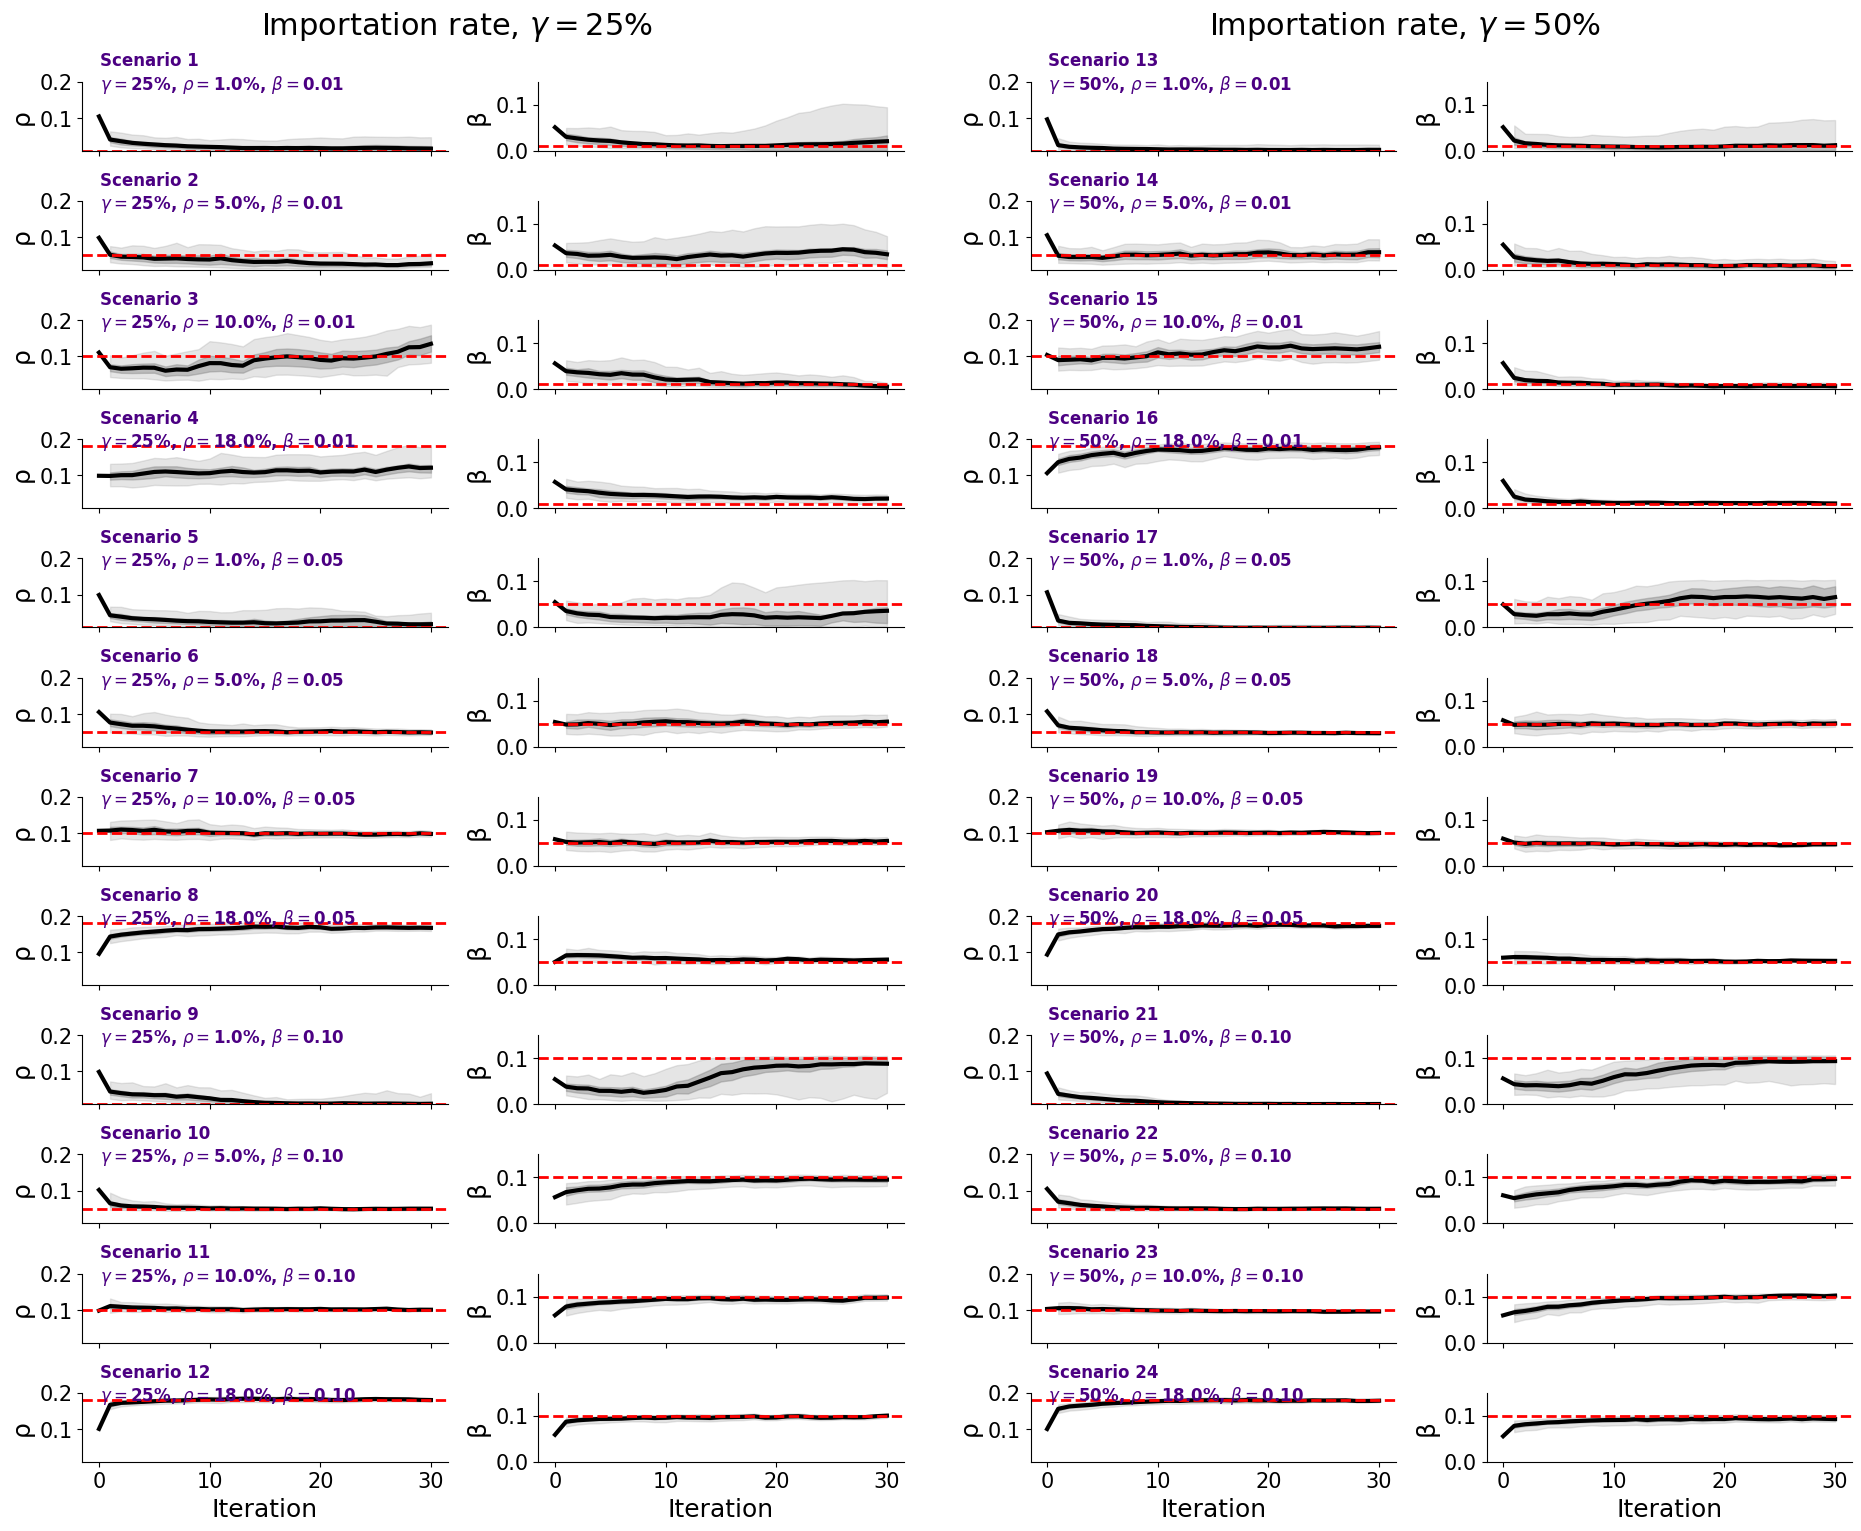

In [9]:
from utils import create_df_response

gammas = [0.25, 0.50]

path_to_save_fig = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", "figures")
id_run           = 0

figg     = plt.figure(constrained_layout=True, figsize=(18.5, 15.2))
subfigs = figg.subfigures(1, 2, hspace=0.05, wspace=0.05, width_ratios=[0.5, 0.5])

for idx_gamma, gamma in enumerate(gammas):
    sce_df = scenarios_large_df[scenarios_large_df.gamma==gamma]
    i_ax   = 0

    #fig, axes = plt.subplots(len(sce_df), 2, figsize=(10, 18.2), sharex=True, sharey="col")

    fig    = subfigs[idx_gamma]
    axes   = subfigs[idx_gamma].subplots(len(sce_df), 2, sharex=True, sharey="col")

    for idx_row, row in sce_df.iterrows():

        path_to_samples   = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", row["scenario"], "infer_building", f"scenario{idx_row+1}")
        samples_inference = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

        θpost = samples_inference["posterior"]
        θmle  = samples_inference["mle"]
        Nif   = θpost.shape[-1]
        θpost = θpost[:, :, :, :].mean(-2)

        ρ_df = create_df_response(θpost[0, :, :].T, time=Nif)
        β_df = create_df_response(θpost[1, :, :].T, time=Nif)

        p_dfs       = [ρ_df, β_df]
        param_label = ["ρ", "β"]
        p_truth     = [row.rho, row.beta]

        parameters_range  = np.array([[0.01, 20/100], [0, 0.15]])

        convergence_plot(θmle, p_dfs, parameters_range, param_label, ax=axes[i_ax, :], fig=fig, param_truth=p_truth)

        axes[i_ax, 0].legend().remove(); axes[i_ax, 1].legend().remove()
        axes[i_ax, 1].set_xlabel(None)
        axes[i_ax, 0].spines['right'].set_visible(False)
        axes[i_ax, 0].spines['top'].set_visible(False)

        axes[i_ax, 1].spines['right'].set_visible(False)
        axes[i_ax, 1].spines['top'].set_visible(False)
        axes[i_ax, 0].text(x=0.1, y=0.18,
                            s        = f"Scenario {idx_row+1} \n"+r"$\gamma=${:0.0f}%, $\rho=${:0.1f}%, $\beta=${:0.2f}".format(row.gamma*100, row.rho*100, row.beta),
                            weight   = 'bold',
                            color    = "indigo",
                            fontsize = 12)
        i_ax += 1

    fig.suptitle(r"Importation rate, $\gamma=${:}%".format(int(gamma*100)))
    axes[0, 0].legend().remove()
    axes[-1, 0].set_xlabel("Iteration")
    axes[-1, 1].set_xlabel("Iteration")

figg.savefig(os.path.join(results2_dir, "paper_figures", "si_figures", "ConvergencePlots_figS7.png"),
                                                                                        dpi         = 300,
                                                                                        transparent = True,
                                                                                        bbox_inches = 'tight')